# Notebook 02: Implementación del Mountain Car Continuous
## Realizado por Víctor Vega Sobral

El objetivo de este notebook es implementar un modelo satisfactorio del problema del coche de la montaña, de la librería de OpenAI gymnasium. 

De esta forma, se podrá tener dos modelos de diferente complejidad en esta práctica y observar diferentes formas de afronar un problema de aprendizaje por refuerzo.



<div style="text-align: center;">
  <img src="images/car.png" alt="Imagen coche " width="350">
</div>


## Importación de bibliotecas necesarias

In [10]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

## Referencias de interés

1. [Documentación oficial de la librería gymnasium](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

2. [Video de youtube con explicación del problema](https://www.youtube.com/watch?v=_SWnNhM5w-g&t=72s)

3. [Imagen de Research Gate con explicación del problema](https://www.researchgate.net/figure/Continuous-Mountain-Car-environment-a-Original-b-Safety-constrained_fig4_366211448)  

## Explicación del problema

Para una correcta explicación del problema, me remito a traducir la explicación ofrecida por la documentación oficial de OpenAI Gymnasium, añadiendo las modificaciones necesarias para adaptar las explicaciones al formato MarkDown, o añadir aclaraciones:

### Descripción
El Mountain Car MDP  consiste en un automóvil colocado aleatoriamente al fondo de un valle sinusoidal. Las únicas acciones posibles son las aceleraciones que se pueden aplicar al coche en cualquiera de las dos direcciones. El objetivo del MDP es acelerar estratégicamente el coche para alcanzar el estado objetivo en la cima de la colina derecha, haciendo uso de la inercia o momentum que este tenga.

Existen dos versiones de este dominio en Gymnasium: una con acciones discretas y otra con acciones continuas. Esta versión utiliza acciones continuas y será la que se intentará resolver en este notebook.





### Espacio de observaciones 

La observación es un ndarray con forma (2,), donde los elementos corresponden a:

| Num | Observación                    | Mínimo | Máximo | Unidad        |
|-----|--------------------------------|--------|--------|---------------|
| 0   | Posición del coche en el eje x | -Inf   | Inf    | posición (m)  |
| 1   | Velocidad del coche            | -Inf   | Inf    | velocidad (m/s) |


### Espacio de acciones
La acción es un ndarray con forma (1,), que representa la fuerza direccional aplicada al coche. La acción se limita al rango [-1,1] y se multiplica por una potencia de 0.0015.

### Dinámica de transición
Dada una acción, el coche sigue las siguientes dinámicas de transición:


$velocity(t+1) = velocity(t) + force * self.power - 0.0025 * cos(3 * position(t))$

$position(t+1) = position(t) + velocity(t+1)$

Donde:

- **force** es la acción limitada al rango [-1,1].
- **power** es una constante de 0.0015.
- **Las colisiones en cualquiera de los extremos son inelásticas**, con la velocidad establecida en 0 al chocar con la pared. La posición se limita al rango [-1.2, 0.6] y la velocidad al rango [-0.07, 0.07].

### Recompensa
Se recibe una recompensa negativa de $-0.1 * action^2$ en cada paso de tiempo para penalizar acciones de gran magnitud. 

Si el coche alcanza el objetivo, se añade una recompensa positiva de +100 a la recompensa negativa de ese paso.

### Estado inicial
1. La **posición inicial** del coche se asigna aleatoriamente dentro del rango [-0.6, -0.4].
2. La **velocidad inicial** del coche siempre es 0.


### Fin del episodio
El episodio termina si ocurre cualquiera de las siguientes condiciones:

- **Terminación:** La posición del coche es mayor o igual a 0.45 (posición objetivo en la cima de la colina derecha).
- **Truncamiento**: La duración del episodio alcanza los 999 pasos.



## ¿Cómo se va a abordar el problema?

Para intentar solucionar este problema, se va a seguir la siguiente estrategia de resolución, resumida en esta ilustración que he realizado basándome en la información del video de Youtube:

<div style="text-align: center;">
  <img src="images/explicacion_car.png" alt="Imagen de explicación del coche " width="400">
</div>


### Q-learning para el entrenamiento del agente

Q-learning es un algoritmo de aprendizaje por refuerzo que busca enseñar al agente a tomar decisiones óptimas basándose en el entorno.

1. **Tabla de búsqueda**: 
    - El resultado final del entrenamiento con Q-learning es una tabla que contiene valores para cada combinación de estado (en este caso, velocidad y posición) y acción.
    - Cada valor representa una estimación del beneficio de tomar una decisión específica en dicho estado.
    - Esto se observa en las estiquetas $P_0$ y $V_0$, que llevan a una acción en la tabla Q.

2. **Decisión basada en valores máximos**: 
    - Siguiendo el ejemplo de la tabla, el agente seleccionará 0.3. Esto se debe a que en Q-learning, para un estado dado, la acción óptima es aquella que tiene el valor más alto en la tabla. 

3. **Adaptación al modelo continuo**: en este caso, a diferencia de problemas con estados discretos, el entorno de Mountain Car tiene un número infinito de combinaciones de posición y velocidad debido a su naturaleza.

    - Por tanto, se divide el espacio de posición y velocidad en segmentos o intervalos, como se observa en la ilustración.

    - Cada segmento representa un estado discreto, por tantno, si la posición del coche es $P_0$, se le asignará el estado 0, y lo mismo ocurre con la velocidad.

### Implementación en el código

Se procede a implementar en código para la resolución del agente.






## Creación de un entorno de prueba

Primero, creamos un entorno de prueba para comprobar que el modelo se está renderizando correctamente en el Notebook. Posteriormente, se comentarán estas líneas de código para que no bloqueen la ejecución de las celdas posteriores.


In [11]:
# def run():

#     env = gym.make('MountainCar-v0', render_mode= 'human')

#     state = env.reset()[0] # Posicion de salida, con la velocidad siempre a 0.
#     terminated = False # Booleano que pasa a True cuando se lllega a la terminacion: se alcanza la meta


#     rewards = 0

#     while(not terminated and rewards> -1000):
        
#         # Escogemos una accion aleatoria (0= conduce a la izquierda, 1= neutral, 2= derecha)
#         action = env.action_space.sample()

#         new_state, reward, terminated,_,_ = env.step(action)

#         state = new_state

#         rewards += reward
#     env.close()

# if __name__ == '__main__':
#     run()

El resultado es correcto, por lo que se procede a realizar los cambios al código en base a este esqueleto. Para mayor claridad, se dividirá el código en diferentes funciones, cada una encargada de un aspecto diferente, para luego integrarlas todas en un bucle de lógica principal.

#### Creación del entorno

Creamos el entorno de gymnasium, estableciendo el parámetro render= False que nos indica que no se debe renderizar el modelo.

Se devuelve la variable env, donde solo se activará la renderización humana si el booleano render está en True.

In [12]:
def create_environment(render=False):
    """
    Creación del environment de gymnasium

    Args: 
        render: indica si se debe renderizar la ventana de Pygame o no

    Returns:
        env: variable encargada de renderizar la pantalla.
    """
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)
    return env


#### Creación de los segmentos de estado

Se crean los segmentos de estado posiciones y velocidades, concretamente en 20, con los valores estipulados anteriormente.

- Posición: entre -1.7 y 1.7.
- Velocidad: entre -0.07 y 0.07.


In [13]:
def create_state_spaces(env, segments=20):
    """
    Se crean los segmentos de estados, con los intervalos específicos

    Args:
        env: entorno del agente
        segments: número de segmentos a dividir

    Returns:
        pos_space: intervalos de posición entre -1.7 y 1.7
        vel_space: intervalos de velocidades entre -0.07 y 0.07
    """
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], segments)
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], segments)
    return pos_space, vel_space

#### Inicialización de la tabla Q

Se inicializa como un array de 20x20x3: 20 segmentos de posiciones y velocidades, con 3 acciones posibles.



In [14]:
def initialize_q_table(pos_space, vel_space, action_space, is_training=True, file_name='mountain_car.pkl'):
    """
    Inicialización de la tabla q

    Args:
        pos_space: intervalos de posicion
        vel_space: intervalos de velocidad
        action_space: entorno de acción
        is_training: indica si se está entrenando o no el modelo
        file_name: en caso contrario a is_training, se carga el archivo de los pesos
    Returns:
        q: tabla Q, array 20x20x3, con 20 segmentos de posiciones y velocidades y 3 accione por tomar
    """
    
    if is_training:
        q = np.zeros((len(pos_space), len(vel_space), action_space.n))
    else:
        with open(file_name, 'rb') as f:
            q = pickle.load(f)
    return q

#### Discretización del estado
Clasificamos las coordenadas del estado de un sistema (posiciones y velocidades) dentro de intervalos predefinidos.

In [15]:
def discretize_state(state, pos_space, vel_space):
    """
    Función para discretizar el estado a través de intervalos
    Se establece la posicion del coche a traves de digitize, que nos devuelve
    en qué segmento se encuentra

    Args: 
        state: estado
        pos_space: espacio de posicion en el que se encuentra el coche
        vel_space: espacio de velocidad 

    Returns:
        state_p: estado actual de posicion del coche
        state_v: estado actual de velocidad del coche
    """
    state_p = np.digitize(state[0], pos_space)
    state_v = np.digitize(state[1], vel_space)
    return state_p, state_v

#### Selección de la acción

El agente escoge qué decisión tomar. Puede escoger una accion aleatoria (0= conduce a la izquierda, 1= neutral, 2= derecha) si el número generado aleatorio es menor que epsilon (establecido como número de acciones aleatorias), o bien elegir una acción a través del valor máximo de la tabla Q como se explicó anteriormente en el funcionamiento del algoritmo de Q-learning.


In [16]:
def select_action(q, state_p, state_v, epsilon, env, rng, is_training):
    """
    El agente selecciona la acción a llevar a cabo.
    Si se está entrenando y se cumple que el número random es menor a epsilon,
    se toma una acción aleatoria.
    En caso contrario, se va a la tabla q y escoge el valor máximo.
    Args: 
        q: tabla q
        state_p: estado actual de posicion del coche
        state_v: estado actual de velocidad del coche
        epsilon: número de deciciones aleatorias que toma el agente
        env: entorno
        rng: generador de números aleatorios
        is_training: booleano para saber si se está entrenando el modelo

    Returns:
        action: acción llevada a cabo por el agente
    """
    if is_training and rng.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q[state_p, state_v, :])
    return action

#### Actualización de la tabla q 

Se van actualizando los valores de la tabla q, a través de la *Ecuación de Bellman*:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \cdot \left[ r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Donde:

- \( Q(s, a) \): Valor Q actual para el estado \( s \) y la acción \( a \).
- \( $\alpha$): Tasa de aprendizaje (*learning rate*).
- \( $r \): Recompensa inmediata obtenida al tomar la acción \( a \) en el estado \( s \).
- \( $\gamma$): Factor de descuento (*discount factor*), que pondera las recompensas futuras.
- \( $\max_{a'} Q(s', a')$): Estimación del valor futuro máximo esperado desde el nuevo estado \( s' \).
- \( $s$ ): Estado actual.
- \( $a$ ): Acción tomada.
- \( $s$' ): Nuevo estado alcanzado después de tomar la acción \( a \).
- \( $a$' ): Todas las acciones posibles desde el nuevo estado \( s' \).



In [17]:
def update_q_table(q, state_p, state_v, action, reward, new_state_p, new_state_v, learning_rate, discount_factor):
    """
    Actualiza la tabla Q utilizando la ecuación de Bellman en Q-learning.

    La actualización se realiza de acuerdo a la fórmula:
    Q(s, a) ← Q(s, a) + α * [r + γ * max_a' Q(s', a') - Q(s, a)]
    
    Args:
        q (np.ndarray): La tabla Q, que almacena los valores de acción-estado.
        state_p (int): Índice del estado actual en el espacio de posiciones.
        state_v (int): Índice del estado actual en el espacio de velocidades.
        action (int): Acción tomada en el estado actual (0, 1, o 2).
        reward (float): Recompensa obtenida por tomar la acción en el estado.
        new_state_p (int): Índice del nuevo estado de posición después de la acción.
        new_state_v (int): Índice del nuevo estado de velocidad después de la acción.
        learning_rate_a (float): Tasa de aprendizaje (α).
        discount_factor_g (float): Factor de descuento (γ) para la recompensa futura.

    Returns:
        np.ndarray: La tabla Q actualizada con el nuevo valor para el estado-acción.
    """
    
    q[state_p, state_v, action] += learning_rate * (
        reward + discount_factor * np.max(q[new_state_p, new_state_v, :]) - q[state_p, state_v, action]
    )

#### Se guarda la tabla q

Guardamos la tabla q al final del entrenamiento, guardándolo como un archivo de pesos .pkl con la librería *pickle*

In [18]:
def save_q_table(q, file_name='mountain_car.pkl'):
    """
    Guarda la tabla Q en un archivo utilizando pickle.

    Esta función serializa la tabla Q y la guarda en un archivo para poder cargarla
    posteriormente y continuar el entrenamiento o simplemente utilizar el modelo entrenado.

    Args:
        q (np.ndarray): La tabla Q que se desea guardar.
        filename (str): Nombre del archivo donde se guardará la tabla Q (por defecto 'mountain_car.pkl').

    Returns:
        None: Esta función no devuelve nada, guarda directamente el archivo en el disco.
    """
    with open(file_name, 'wb') as f:
        pickle.dump(q, f)

#### Graficamos las recompensas

Una vez entrenado el modelo, se grafican las recompensas que se han ido obteniendo durante el entrenamiento, para su posterior análisis en otro punto.


In [19]:
def plot_rewards(rewards_per_episode, episodes, smoothing_window=100):
    """
    Dibuja y guarda un gráfico de las recompensas medias por episodio.

    Esta función calcula la recompensa media de los últimos 100 episodios y
    genera un gráfico de recompensas durante el entrenamiento.

    Args:
        rewards_per_episode (np.ndarray): Arreglo que contiene las recompensas obtenidas en cada episodio.
        episodes (int): Número total de episodios.
        filename (str): Nombre del archivo donde se guardará la gráfica (por defecto 'grafico_mountain_car.png').

    Returns:
        None: Esta función no devuelve nada, guarda directamente la gráfica en un archivo.
    """
    
    
    # Cálculo de recompensas promedio
    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t - smoothing_window): (t + 1)])
    
    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(mean_rewards, label='Recompensa Promedio', color='blue')
    
    # Personalizar eje y para mostrar rango positivo
    min_reward = min(0, min(mean_rewards))  # Aseguramos que el mínimo no sea menor a 0
    max_reward = max(mean_rewards) + 10    # Espacio extra por encima del máximo
    plt.ylim(min_reward, max_reward)
    
    # Añadir línea base en y=0 para referencia
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    
    # Etiquetas y título
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa promedio')
    plt.title('Evolución de las recompensas promedio')
    plt.legend()
    plt.grid(alpha=0.3)

    # Guardar o mostrar la gráfica
    plt.savefig('grafico_mountain_car.png')
    plt.show()

#### Se ejecuta un episodio

La siguiente función contempla la ejecución de un episodio del agente.

In [20]:
def run_episode(env, q, pos_space, vel_space, epsilon, rng, is_training, learning_rate, discount_factor):
    """
    Ejecuta un solo episodio de entrenamiento o evaluación en el entorno de MountainCar.

    Este método simula un episodio en el entorno y, dependiendo de si estamos entrenando o no,
    actualiza la tabla Q con la información de cada paso del episodio.

    Args:
        env (gym.Env): El entorno de MountainCar.
        q (np.ndarray): La tabla Q que se actualiza durante el entrenamiento.
        is_training (bool): Si True, actualiza la tabla Q. Si False, usa la tabla Q entrenada.
        pos_space (np.ndarray): Espacio de posiciones dividido en segmentos.
        vel_space (np.ndarray): Espacio de velocidades dividido en segmentos.
        epsilon (float): Tasa de exploración (probabilidad de tomar acciones aleatorias).
        learning_rate_a (float): Tasa de aprendizaje (alpha).
        discount_factor_g (float): Factor de descuento (gamma) para recompensas futuras.

    Returns:
        tuple: Una tupla que contiene:
            - rewards (float): La recompensa total obtenida en el episodio.
            - epsilon (float): El valor actualizado de epsilon después de este episodio.
    """
    
    state = env.reset()[0]
    state_p, state_v = discretize_state(state, pos_space, vel_space)

    terminated = False
    rewards = 0

    while not terminated and rewards > -1000:
        action = select_action(q, state_p, state_v, epsilon, env, rng, is_training)
        new_state, reward, terminated, _, _ = env.step(action)
        new_state_p, new_state_v = discretize_state(new_state, pos_space, vel_space)

        if is_training:
            update_q_table(q, state_p, state_v, action, reward, new_state_p, new_state_v, learning_rate, discount_factor)

        state_p, state_v = new_state_p, new_state_v
        rewards += reward

    return rewards


#### Ajuste de epsilon

Para ir ajustando el número de acciones aleatorias del agente, se crea una función que vaya ajustando epsilon conforme los episodios van pasando.

In [21]:
def adjust_epsilon(epsilon, decay_rate):
    """
    Ajusta el valor de epsilon para reducir la exploración a medida que avanza el entrenamiento.

    La tasa de exploración decae gradualmente a medida que el entrenamiento avanza, permitiendo
    que el agente confíe más en la política aprendida.

    Args:
        epsilon (float): Tasa de exploración actual.
        epsilon_decay_rate (float): Tasa de decaimiento de epsilon.
        episode (int): El número del episodio actual.
        min_epsilon (float): El valor mínimo de epsilon (por defecto 0).

    Returns:
        float: El valor ajustado de epsilon para el siguiente episodio.
    """
    return max(epsilon - decay_rate, 0)


#### Lógica principal del programa
La función `run` es la encargada de controlar el flujo completo de entrenamiento o evaluación del agente en el entorno de MountainCar. 

Su propósito es ejecutar una serie de episodios, durante los cuales el agente interactúa con el entorno, toma decisiones basadas en su tabla Q, y actualiza la tabla Q según lo aprendido.

En esta función, usamos todas las demás anteriores, consiguiendo tener una lógica principal bastante más legible y eficiente.

1. **Inicialización:**
   - Se configura el entorno de MountainCar usando `gym.make()`.
   - Se dividen el espacio de posiciones y velocidades en segmentos usando `np.linspace()` para crear un mapeo discreto.
   - Si el agente está en modo de entrenamiento, se inicializa una tabla Q de tamaño correspondiente. Si está en modo de evaluación, se carga una tabla Q previamente entrenada desde un archivo.

2. **Ajuste de parámetros:**
   - Se inicializan varios parámetros como `epsilon`, `learning_rate_a` y `discount_factor_g`.
   - `epsilon` empieza en 1, lo que significa que el agente explorará completamente al principio. A medida que avanzan los episodios, `epsilon` decae, lo que lleva al agente a explotar más su conocimiento y explorar menos.

3. **Ejecutando episodios:**
   - La función ejecuta un número de episodios (`episodes`). En cada episodio, se llama a la función `run_episode`, que maneja la interacción del agente con el entorno. El agente toma acciones basadas en la política ε-greedy y actualiza la tabla Q según las recompensas obtenidas.

4. **Ajuste de epsilon:**
   - Después de cada episodio, se ajusta el valor de `epsilon` utilizando la función `adjust_epsilon`. Esto reduce la tasa de exploración a medida que el agente gana más experiencia.

5. **Guardar resultados:**
   - Si el agente está entrenando, se guarda la tabla Q al final del entrenamiento usando `save_q_table`.
   - Además, se genera y guarda un gráfico con las recompensas medias por episodio utilizando la función `plot_rewards`.

Por tanto, `run` organiza el ciclo completo de entrenamiento o evaluación, permitiendo que el agente aprenda o utilice una política preexistente mientras ajusta parámetros clave a lo largo de los episodios.

In [22]:
def run(episodes, is_training=True, render=False):
    """
    Ejecuta el proceso completo de entrenamiento o evaluación del agente en el entorno de MountainCar.

    Esta función organiza el ciclo completo de entrenamiento del agente, incluyendo la inicialización
    de la tabla Q, la ejecución de los episodios y la actualización de parámetros como epsilon.

    Args:
        episodes (int): El número de episodios que se ejecutarán.
        is_training (bool): Si True, entrena al agente. Si False, evalúa al agente con el modelo entrenado.
        render (bool): Si True, muestra el entorno visualmente.

    Returns:
        None: La función no devuelve nada, pero guarda los resultados de la tabla Q y las recompensas.
    """
    env = create_environment(render)
    pos_space, vel_space = create_state_spaces(env)
    q = initialize_q_table(pos_space, vel_space, env.action_space, is_training)

    learning_rate = 0.9
    discount_factor = 0.9
    epsilon = 1.0
    epsilon_decay_rate = 2 / episodes
    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        if is_training and (i + 1) % 100 == 0:
            print(f"Entrenando... Episodio {i + 1} de {episodes}")

        rewards_per_episode[i] = run_episode(
            env, q, pos_space, vel_space, epsilon, rng, 
            is_training, learning_rate, discount_factor
        )

        epsilon = adjust_epsilon(epsilon, epsilon_decay_rate)

    env.close()

    if is_training:
        save_q_table(q)

    plot_rewards(rewards_per_episode, episodes)


#### Entrenamiento del modelo

A continuación, se entrena el modelo, con 5000 episodios.

Entrenando... Episodio 100 de 5000
Entrenando... Episodio 200 de 5000
Entrenando... Episodio 300 de 5000
Entrenando... Episodio 400 de 5000
Entrenando... Episodio 500 de 5000
Entrenando... Episodio 600 de 5000
Entrenando... Episodio 700 de 5000
Entrenando... Episodio 800 de 5000
Entrenando... Episodio 900 de 5000
Entrenando... Episodio 1000 de 5000
Entrenando... Episodio 1100 de 5000
Entrenando... Episodio 1200 de 5000
Entrenando... Episodio 1300 de 5000
Entrenando... Episodio 1400 de 5000
Entrenando... Episodio 1500 de 5000
Entrenando... Episodio 1600 de 5000
Entrenando... Episodio 1700 de 5000
Entrenando... Episodio 1800 de 5000
Entrenando... Episodio 1900 de 5000
Entrenando... Episodio 2000 de 5000
Entrenando... Episodio 2100 de 5000
Entrenando... Episodio 2200 de 5000
Entrenando... Episodio 2300 de 5000
Entrenando... Episodio 2400 de 5000
Entrenando... Episodio 2500 de 5000
Entrenando... Episodio 2600 de 5000
Entrenando... Episodio 2700 de 5000
Entrenando... Episodio 2800 de 5000
E

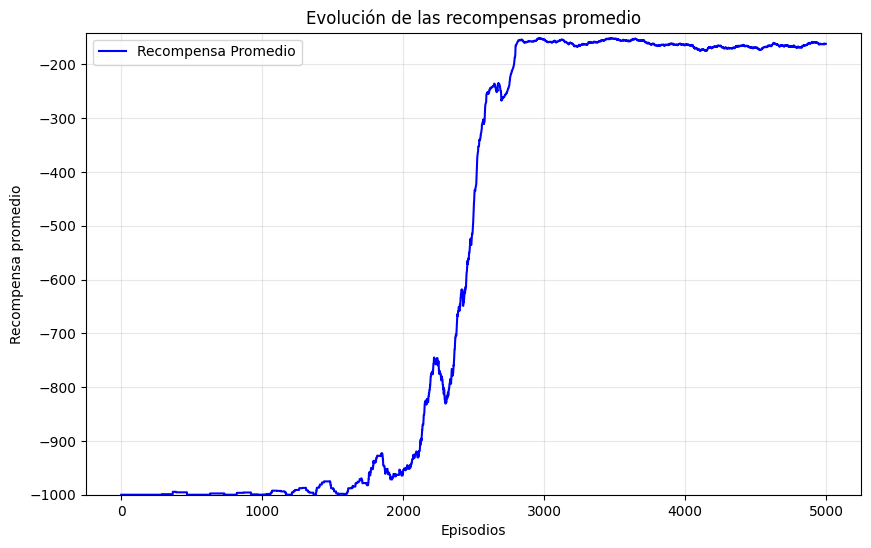

In [23]:
# Entrenamos el modelo
if __name__ == '__main__':
    run(5000, is_training= True, render = False)

### Conclusiones de la gráfica

Como se puede observar, en **los primeros 1000 episodios** las recompensas son muy negativas, lo que indica que el agente no es capaz de llegar correctamente a la meta y además ejecuta casi todas sus acciones de forma aleatoria.

Sin embargo, a medida que el valor de epsilon decae, en el **episodio 1100** se puede obervar que las recompensas comienzan a crecer. Esto indica que el agente es capaz poco a poco de llegar a la meta realizando cada vez menos acciones aleatorias.

**A partir del episodio 2000**, el aumento en la recompensa sube drásticamente salvando leves picos de bajada, estabilizándose cerca de la iteración 2800 en valores muy cercanos al 0. Esto nos indica que el número de acciones aleatorias es cada vez más pequeño y el agente está usando acciones almacenadas en la tabla Q.

**A partir de la iteración 3000**, las recompensas crecen ligeramente y se estabilizan, indicándonos que el modelo es capaz de llegar a la meta en pocos pasos y usando en la inmensa mayor parte de sus acciones el conocimiento que alberga en la tabla Q.

#### Prueba de ejecución con los pesos

Finalmente, se prueba nuestro modelo a partir de los pesos obtenidos anteriormente. Este modelo también ofrecerá una gráfica con las recompensas del modelo, pero no resulta muy significativa, puesto que el modelo ya ha sido entrenado y se quiere verificar su correcto funcionamiento.

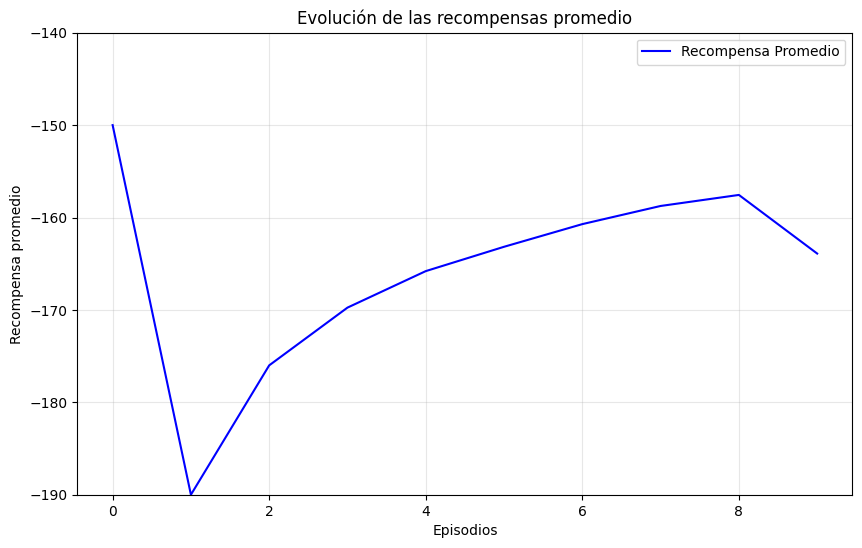

In [24]:
# Entrenamos el modelo
if __name__ == '__main__':
    run(10, is_training= False, render = True)

## Conclusiones

Como conclusiones, se pueden extraer diferentes ideas.

1. La primera de todas es que, tras ejecutar el modelo y visualizar los datos ofrecidos por la gráfica, **el modelo es capaz de llegar satisfactoriamente a la meta en pocos pasos**, tomando como accciones las definidas en la tabla Q.

2. Como segunda conclusión, **este segundo notebook ha servido para implementar otro algoritmo diferente de aprendizaje por refuerzo**, enriqueciendo el contenido y conocimientos adquiridos y probando otro modelo diferente de OpenAI Gymnasium.

3. Finalmente, **los materiales y código realizados** ofrecen dos agentes bastante satisfactorios, salvaguardando la diferencia de complejidad entre ellos. A continuación, se procederá a actualizar el repositorio con el código final de la práctica.